In [ ]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import random

# NetworkX
import networkx as nx
from networkx.algorithms.components import connected_components
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.distance_measures import eccentricity, diameter
from networkx.algorithms import bipartite
from networkx.algorithms.community import greedy_modularity_communities

#Misspelling algorithm
import csv
from collections import defaultdict
import Levenshtein
import os

# Bipartite graph
from collections import Counter
from scipy import stats

# Neo4j
import neo4j

# Hero-Hero Recommender System
from sklearn.metrics.pairwise import cosine_similarity

# 1. Network Source

**Primary source**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

**Data components**:
- `nodes.csv`: Contains node identifiers and types (hero or comic)
- `edges.csv`: Contains hero-comic relationships (which heroes appear in which comics)

# 2. Data Persistence

**Saves the data in a Neo4J Database**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)


In [3]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
# credentials ..
username = "neo4j"
password = "password"

driver = GraphDatabase.driver(uri, auth=("neo4j", ""))

# Load the datasets
nodes_df = pd.read_csv('Data/nodes_corr.csv')
edges_df = pd.read_csv('Data/edges_corr.csv')
hero_network_df = pd.read_csv('Data/hero-network.csv')

def insert_data(tx, data):
    hero = row['hero']
    comic = row['comic']
    cypher_query = '''MERGE (h:Hero {name: $hero})
        MERGE (c:Comic {name: $comic})
        MERGE (h)-[:APPEARED_IN]->(c)'''
    tx.run(cypher_query, hero=hero, comic=comic)


# Iterate through hero dataset ..
with driver.session() as session:
    for index, row in edges_df.iterrows():
        session.write_transaction(insert_data, row)

driver.close()

/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_4866/1221509584.py:27: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_data, row)


# 2. Data Loading

In [ ]:

def fetch_data(tx):
    get_query = '''MATCH (h:Hero)-[:APPEARED_IN]->(c:Comic)
    RETURN h.name AS hero, c.name AS comic'''
    result = tx.run(get_query)
    return [record.data() for record in result]

with driver.session() as session:
    edges_df = session.read_transaction(fetch_data)
#     edges_df = pd.DataFrame(edges_df)

# print(edges_df.head())


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_4866/1016300443.py:7: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_4866/1016300443.py:8: DeprecationWarning: read_transaction has been renamed to execute_read
  edges_df = session.read_transaction(fetch_data)


                   hero   comic
0  24-HOUR MAN/EMMANUEL  AA2 35
1  3-D MAN/CHARLES CHAN   AVF 4
2  3-D MAN/CHARLES CHAN   AVF 5
3  3-D MAN/CHARLES CHAN   COC 1
4  3-D MAN/CHARLES CHAN  H2 251


In [3]:
#load data manually if neo4j is not available
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')

# 3. Data Quality and Preprocessing

## 3.1. Quality check 

### 3.1.1 Misspelling mistakes

This script analyzes hero names across two DataFrames (edges_df and nodes_df) to identify potential spelling inconsistencies in hero and comic names.

In [7]:
# Configuration
SIMILARITY_THRESHOLD = 0.8  # Minimum similarity to consider (0-1)
MIN_NAME_LENGTH = 4  # Minimum name length to compare
OUTPUT_PREFIX = 'entity_spelling_results'  # Output file prefix
RESULT_LIMIT = None  # Limit number of results (None for all)

In [8]:
# Function to load entity names from DataFrames
def load_entity_names_from_dataframes(edges_df, nodes_df):
    """
    Load hero and comic names from existing DataFrames and track their sources.
    
    Returns:
        dict: A dictionary with entity names as keys and a dict of info as values
    """
    entity_sources = defaultdict(lambda: {'type': None, 'edges': False, 'nodes': False})
    
    # Load heroes from edges_df
    try:
        for hero in edges_df['hero'].unique():
            entity_sources[hero]['type'] = 'hero'
            entity_sources[hero]['edges'] = True
        print(f"Loaded {len(edges_df['hero'].unique())} unique heroes from edges_df")
    except Exception as e:
        print(f"Error processing heroes in edges_df: {e}")
    
    # Load comics from edges_df
    try:
        for comic in edges_df['comic'].unique():
            entity_sources[comic]['type'] = 'comic'
            entity_sources[comic]['edges'] = True
        print(f"Loaded {len(edges_df['comic'].unique())} unique comics from edges_df")
    except Exception as e:
        print(f"Error processing comics in edges_df: {e}")
    
    # Load from nodes_df
    try:
        # Load heroes from nodes_df
        hero_nodes = nodes_df[nodes_df['type'] == 'hero']
        for hero in hero_nodes['node'].unique():
            entity_sources[hero]['type'] = 'hero'
            entity_sources[hero]['nodes'] = True
        print(f"Loaded {len(hero_nodes['node'].unique())} unique heroes from nodes_df")
        
        # Load comics from nodes_df
        comic_nodes = nodes_df[nodes_df['type'] == 'comic']
        for comic in comic_nodes['node'].unique():
            entity_sources[comic]['type'] = 'comic'
            entity_sources[comic]['nodes'] = True
        print(f"Loaded {len(comic_nodes['node'].unique())} unique comics from nodes_df")
    except Exception as e:
        print(f"Error processing nodes_df: {e}")
    
    heroes_count = sum(1 for info in entity_sources.values() if info['type'] == 'hero')
    comics_count = sum(1 for info in entity_sources.values() if info['type'] == 'comic')
    print(f"Total unique entities: {len(entity_sources)} ({heroes_count} heroes, {comics_count} comics)")
    
    return entity_sources


def calculate_similarity(str1, str2):
    """
    Calculate string similarity based on Levenshtein distance.
    
    Returns:
        float: Similarity score between 0 and 1
    """
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len) if max_len > 0 else 1


def find_similar_names(entity_sources, threshold=0.8, min_length=4):
    """
    Find entity names that are similar but not identical.
    
    Args:
        entity_sources: Dictionary of entity names and their sources
        threshold: Minimum similarity score to consider (default: 0.8)
        min_length: Minimum length of names to compare (default: 4)
        
    Returns:
        dict: Dictionary with 'heroes' and 'comics' keys containing lists of similar pairs
    """
    similar_pairs = {'heroes': [], 'comics': []}
    processed_pairs = set()
    
    # Separate heroes and comics
    heroes = [name for name, info in entity_sources.items() if info['type'] == 'hero']
    comics = [name for name, info in entity_sources.items() if info['type'] == 'comic']
    
    # Sort by length for optimization
    heroes.sort(key=len)
    comics.sort(key=len)
    
    # Process heroes
    print(f"Finding similar hero names (threshold: {threshold}, min length: {min_length})...")
    total_heroes = len(heroes)
    
    for i, hero1 in enumerate(heroes):
        if len(hero1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total_heroes} heroes processed...")
            
        for hero2 in heroes[i+1:]:
            # Skip if second hero is much longer (optimization)
            if len(hero2) > len(hero1) * 1.5:
                break
                
            # Skip very short names
            if len(hero2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([hero1, hero2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(hero1, hero2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs['heroes'].append({
                    'entity1': hero1,
                    'entity2': hero2,
                    'similarity': similarity,
                    'sources1': entity_sources[hero1],
                    'sources2': entity_sources[hero2]
                })
    
    # Reset processed pairs for comics
    processed_pairs = set()
    
    # Process comics
    print(f"Finding similar comic names (threshold: {threshold}, min length: {min_length})...")
    total_comics = len(comics)
    
    for i, comic1 in enumerate(comics):
        if len(comic1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total_comics} comics processed...")
            
        for comic2 in comics[i+1:]:
            # Skip if second comic is much longer (optimization)
            if len(comic2) > len(comic1) * 1.5:
                break
                
            # Skip very short names
            if len(comic2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([comic1, comic2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(comic1, comic2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs['comics'].append({
                    'entity1': comic1,
                    'entity2': comic2,
                    'similarity': similarity,
                    'sources1': entity_sources[comic1],
                    'sources2': entity_sources[comic2]
                })
    
    # Sort by similarity (highest first)
    similar_pairs['heroes'].sort(key=lambda x: x['similarity'], reverse=True)
    similar_pairs['comics'].sort(key=lambda x: x['similarity'], reverse=True)
    
    return similar_pairs


def format_source_info(sources):
    """Format source information for display"""
    source_list = []
    if sources['edges']:
        source_list.append('edges_df')
    if sources['nodes']:
        source_list.append('nodes_df')
    return ', '.join(source_list)


def export_results(similar_pairs, output_prefix):
    """Export results to CSV files"""
    # Export hero results
    hero_output = f"{output_prefix}_heroes.csv"
    with open(hero_output, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Hero Name 1', 'Hero Name 2', 'Similarity (%)', 'Sources for Hero 1', 'Sources for Hero 2'])
        
        for pair in similar_pairs['heroes']:
            writer.writerow([
                pair['entity1'], 
                pair['entity2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Hero results exported to {hero_output}")
    
    # Export comic results
    comic_output = f"{output_prefix}_comics.csv"
    with open(comic_output, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Comic Name 1', 'Comic Name 2', 'Similarity (%)', 'Sources for Comic 1', 'Sources for Comic 2'])
        
        for pair in similar_pairs['comics']:
            writer.writerow([
                pair['entity1'], 
                pair['entity2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Comic results exported to {comic_output}")


# Main function to run the analysis with existing DataFrames
def run_analysis_with_dfs(edges_df, nodes_df):
    """Run the analysis using existing DataFrames"""
    print("Loading entity names from DataFrames...")
    entity_sources = load_entity_names_from_dataframes(edges_df, nodes_df)
    
    similar_pairs = find_similar_names(
        entity_sources, 
        threshold=SIMILARITY_THRESHOLD,
        min_length=MIN_NAME_LENGTH
    )
    
    # Apply result limit if specified
    if RESULT_LIMIT:
        similar_pairs['heroes'] = similar_pairs['heroes'][:RESULT_LIMIT]
        similar_pairs['comics'] = similar_pairs['comics'][:RESULT_LIMIT]
    
    print(f"Found {len(similar_pairs['heroes'])} potential hero name inconsistencies")
    print(f"Found {len(similar_pairs['comics'])} potential comic name inconsistencies")
    
    # Print top hero results
    print("\nTop potential hero inconsistencies:")
    for i, pair in enumerate(similar_pairs['heroes'][:5]):
        print(f"{i+1}. {pair['entity1']} <-> {pair['entity2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['entity1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['entity2']}: {format_source_info(pair['sources2'])}")
        print()
    
    # Print top comic results
    print("\nTop potential comic inconsistencies:")
    for i, pair in enumerate(similar_pairs['comics'][:5]):
        print(f"{i+1}. {pair['entity1']} <-> {pair['entity2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['entity1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['entity2']}: {format_source_info(pair['sources2'])}")
        print()
    
    # Export results to separate files
    export_results(similar_pairs, OUTPUT_PREFIX)
    
    # Create DataFrames for the results
    hero_results_df = pd.DataFrame([
        {
            'Entity 1': pair['entity1'],
            'Entity 2': pair['entity2'],
            'Similarity': pair['similarity'],
            'Sources 1': format_source_info(pair['sources1']),
            'Sources 2': format_source_info(pair['sources2'])
        }
        for pair in similar_pairs['heroes']
    ])
    
    comic_results_df = pd.DataFrame([
        {
            'Entity 1': pair['entity1'],
            'Entity 2': pair['entity2'],
            'Similarity': pair['similarity'],
            'Sources 1': format_source_info(pair['sources1']),
            'Sources 2': format_source_info(pair['sources2'])
        }
        for pair in similar_pairs['comics']
    ])
    
    return {
        'similar_pairs': similar_pairs,
        'hero_results_df': hero_results_df,
        'comic_results_df': comic_results_df
    }



In [9]:
results = run_analysis_with_dfs(edges_df, nodes_df)

results['similar_pairs']  # All similar pairs
results['hero_results_df']  # DataFrame with hero results
results['comic_results_df']  # DataFrame with comic results

Loading entity names from DataFrames...
Loaded 6439 unique heroes from edges_df
Loaded 12651 unique comics from edges_df
Loaded 6439 unique heroes from nodes_df
Loaded 12651 unique comics from nodes_df
Total unique entities: 19091 (6440 heroes, 12651 comics)
Finding similar hero names (threshold: 0.8, min length: 4)...
Progress: 100/6440 heroes processed...
Progress: 200/6440 heroes processed...
Progress: 300/6440 heroes processed...
Progress: 400/6440 heroes processed...
Progress: 500/6440 heroes processed...
Progress: 600/6440 heroes processed...
Progress: 700/6440 heroes processed...
Progress: 800/6440 heroes processed...
Progress: 900/6440 heroes processed...
Progress: 1000/6440 heroes processed...
Progress: 1100/6440 heroes processed...
Progress: 1200/6440 heroes processed...
Progress: 1300/6440 heroes processed...
Progress: 1400/6440 heroes processed...
Progress: 1500/6440 heroes processed...
Progress: 1600/6440 heroes processed...
Progress: 1700/6440 heroes processed...
Progress

,Entity 1,Entity 2,Similarity,Sources 1,Sources 2
0,ALL WINNERS COMICS 1,ALL WINNERS COMICS 2,0.95,"edges_df, nodes_df","edges_df, nodes_df"
1,ALL WINNERS COMICS 1,ALL WINNERS COMICS 3,0.95,"edges_df, nodes_df","edges_df, nodes_df"
2,ALL WINNERS COMICS 1,ALL WINNERS COMICS 4,0.95,"edges_df, nodes_df","edges_df, nodes_df"
3,ALL WINNERS COMICS 1,ALL WINNERS COMICS 5,0.95,"edges_df, nodes_df","edges_df, nodes_df"
4,ALL WINNERS COMICS 1,ALL WINNERS COMICS 7,0.95,"edges_df, nodes_df","edges_df, nodes_df"
...,...,...,...,...,...
95219,M/FAN 46/2,M/FAN 48/3,0.80,"edges_df, nodes_df","edges_df, nodes_df"
95220,M/FAN 46/2,M/FAN 54/2,0.80,"edges_df, nodes_df","edges_df, nodes_df"
95221,M/FAN 46/2,M/FAN 55/2,0.80,"edges_df, nodes_df","edges_df, nodes_df"
95222,PPTSS 12/2,PPTSS 49/2,0.80,"edges_df, nodes_df","edges_df, nodes_df"


After a torough inspection of the pairs with 90% of similarity or more from the outputed `entity_spelling_results_comics.csv` and `entity_spelling_results_heroes.csv`, we can see that there were no inconsistency mistakes in the comics' and heroes' names. This is likely due to the fact that we downloaded a dataset that is commonly used for graph analysis, and has therefore already been preprocessed.

We have corrected manually the spelling mistakes in our datasets and renamed the corrected files as: 
- `edges_corr.csv`
- `nodes_corr.csv`

Regarding the comics, there was no spelling mistake. 

### 3.1.2 Duplicates

In [4]:
# Check duplicates in the edges DataFrame
duplicates = edges_df[edges_df.duplicated(subset=['hero', 'comic'], keep=False)]
duplicates = duplicates.sort_values(by=['hero', 'comic'])
duplicates.reset_index(drop=True, inplace=True)
duplicates

,hero,comic


In [5]:
# Check duplicates in the nodes DataFrame
duplicates_nodes = nodes_df[nodes_df.duplicated(subset=['node', 'type'], keep=False)]
duplicates_nodes = duplicates_nodes.sort_values(by=['node', 'type'])
duplicates_nodes.reset_index(drop=True, inplace=True)
duplicates_nodes

,node,type


## 3.2 Re-load the corrected data

In [6]:
# Load the datasets
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


# 4. Bipartite Graph: Heroes x Comics  
We will create the bipartite graph consisting of heroes and comics nodes, where there is an edge between a hero and a comic if the hero appears in the comic.

In [7]:
# Create the graph (B for bipartite)
B = nx.Graph()

# Add nodes with bipartite attribute
for _, row in nodes_df.iterrows():
    B.add_node(row['node'], bipartite=0 if row['type'] == 'comic' else 1)

# Add edges from edges_df (assuming hero-comic links)
for _, row in edges_df.iterrows():
    B.add_edge(row['hero'], row['comic'])


In [29]:

print(nx.algorithms.bipartite.is_bipartite(B))  # Should return True


True


In [27]:
# Check for nodes added by edges only
all_nodes_in_nodes_df = set(nodes_df['node'])
all_nodes_in_edges_df = set(edges_df['hero']).union(set(edges_df['comic']))
missing_nodes = all_nodes_in_edges_df - all_nodes_in_nodes_df

print("Missing nodes from nodes_df:", missing_nodes)


Missing nodes from nodes_df: set()


## 4.1 Network Exploration

In [30]:
# Split nodes based on the bipartite attribute
comics = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
heroes = set(B) - comics

# Create summary table
summary = pd.DataFrame({
    'Metric': [
        'Number of comics',
        'Number of heroes',
        'Total number of nodes',
        'Number of edges',
        'Average degree (overall)',
        'Average degree (heroes)',
        'Average degree (comics)',
        'Graph density',
        'Is connected?',
        'Number of connected components',
    ],
    'Value': [
        len(comics),
        len(heroes),
        B.number_of_nodes(),
        B.number_of_edges(),
        sum(dict(B.degree()).values()) / B.number_of_nodes(),
        sum(dict(B.degree(heroes)).values()) / len(heroes),
        sum(dict(B.degree(comics)).values()) / len(comics),
        nx.density(B),
        nx.is_connected(B),
        nx.number_connected_components(B),
    ]
})

summary


,Metric,Value
0,Number of comics,12651
1,Number of heroes,6439
2,Total number of nodes,19090
3,Number of edges,96104
4,Average degree (overall),10.068518
5,Average degree (heroes),14.925299
6,Average degree (comics),7.596554
7,Graph density,0.000527
8,Is connected?,False
9,Number of connected components,22


### 4.1.1 Isolated heroes and comics

In [31]:
# Get all isolated nodes (nodes with degree 0)
isolated_nodes = list(nx.isolates(B))

# Separate by type
isolated_comics = [n for n in isolated_nodes if B.nodes[n].get('bipartite') == 0]
isolated_heroes = [n for n in isolated_nodes if B.nodes[n].get('bipartite') == 1]

# Show counts and optionally the actual names
print(f"Number of isolated comics: {len(isolated_comics)}")
print(f"Number of isolated heroes: {len(isolated_heroes)}")

# See their names
print("Isolated comics:", isolated_comics)
print("Isolated heroes:", isolated_heroes)


Number of isolated comics: 0
Number of isolated heroes: 0
Isolated comics: []
Isolated heroes: []


### 4.1.2 Degree distribution

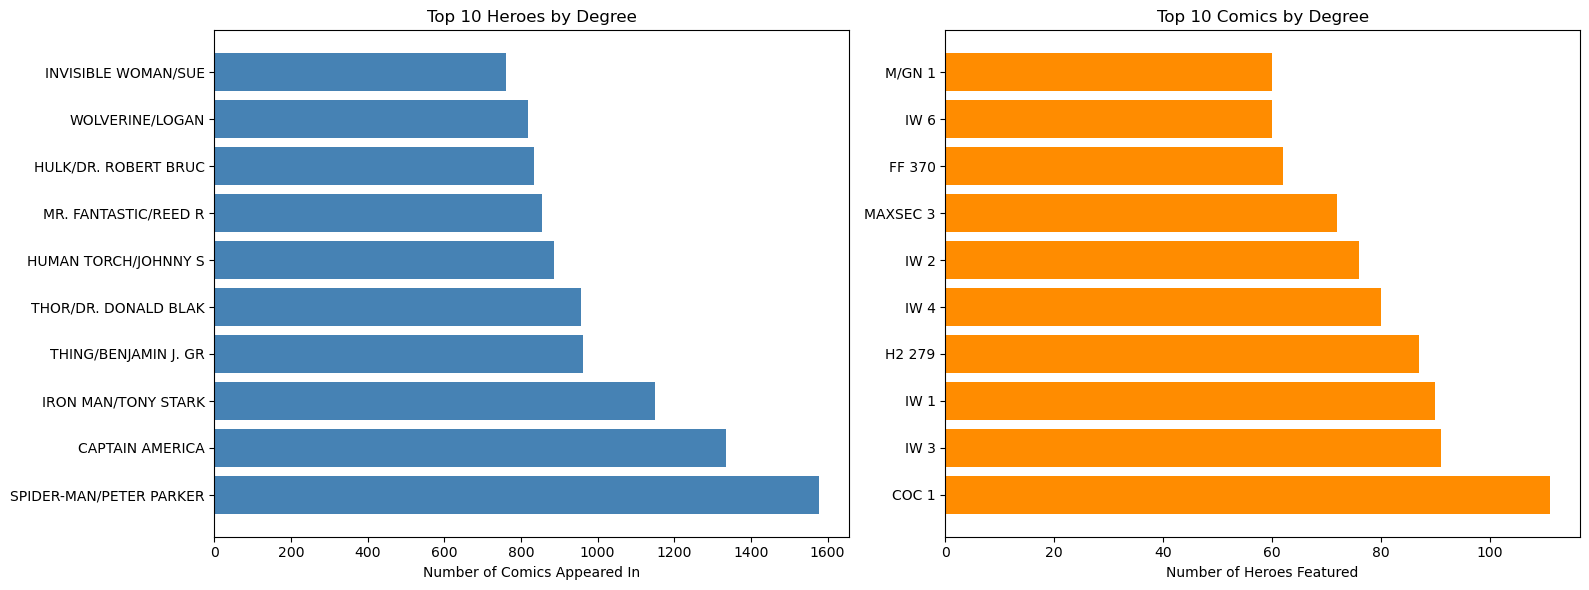

In [32]:
# Get degrees for all nodes
degrees = dict(B.degree())

# Separate degrees by type
comic_degrees = {n: deg for n, deg in degrees.items() if B.nodes[n].get('bipartite') == 0}
hero_degrees = {n: deg for n, deg in degrees.items() if B.nodes[n].get('bipartite') == 1}

# Get top 10 by degree
top_10_comics = sorted(comic_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_heroes = sorted(hero_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heroes
axes[0].barh(
    [name for name, _ in reversed(top_10_heroes)],
    [deg for _, deg in reversed(top_10_heroes)],
    color='steelblue'
)
axes[0].set_title('Top 10 Heroes by Degree')
axes[0].set_xlabel('Number of Comics Appeared In')
axes[0].invert_yaxis()

# Comics
axes[1].barh(
    [name for name, _ in reversed(top_10_comics)],
    [deg for _, deg in reversed(top_10_comics)],
    color='darkorange'
)
axes[1].set_title('Top 10 Comics by Degree')
axes[1].set_xlabel('Number of Heroes Featured')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


### 4.1.3 Path and Reachability

We do those analysis on a subgraph computed like so:
1. Selecting the top 10 comics by degree.
2. Expanding the subgraph to include their immediate neighbors (i.e. all connected heroes for top comics).

In [15]:
# Step 1: Identify comic nodes
comic_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

# Step 2: Compute degree for comic nodes
comic_degrees = {n: B.degree(n) for n in comic_nodes}

# Step 3: Select top N comics by degree
N = 10  
top_comics = sorted(comic_degrees, key=comic_degrees.get, reverse=True)[:N]

# Step 4: Include all connected heroes (neighbours of top comics)
connected_heroes = set()
for comic in top_comics:
    connected_heroes.update(B.neighbors(comic))

# Step 5: Create subgraph with top comics + connected heroes
selected_nodes = set(top_comics) | connected_heroes
B_subgraph = B.subgraph(selected_nodes)

# Count node types in subgraph
comics_subgraph = {n for n in B_subgraph if B_subgraph.nodes[n].get('bipartite') == 0}
heroes_subgraph = {n for n in B_subgraph if B_subgraph.nodes[n].get('bipartite') == 1}

# Quick stats
print("Subgraph Summary:")
print(f"Number of nodes in Subgraph: {B_subgraph.number_of_nodes()}")
print(f" - Comics: {len(comics_subgraph)}")
print(f" - Heroes: {len(heroes_subgraph)}")
print(f"Number of edges in Subgraph: {B_subgraph.number_of_edges()}")



Subgraph Summary:
Number of nodes in Subgraph: 289
 - Comics: 10
 - Heroes: 279
Number of edges in Subgraph: 789


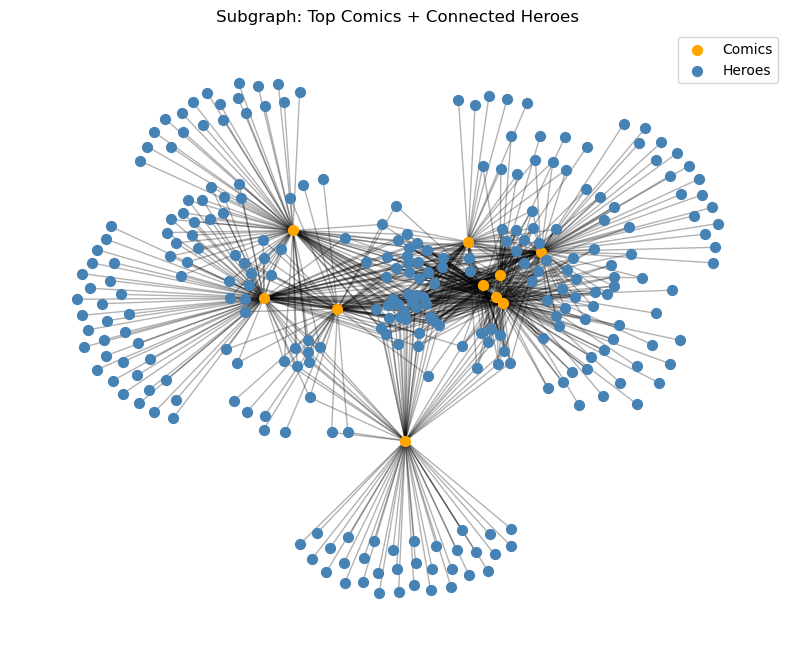

In [16]:
# Visualise subgraph
pos = nx.spring_layout(B_subgraph, seed=42)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(B_subgraph, pos, nodelist=comics_subgraph, node_color='orange', label='Comics', node_size=50)
nx.draw_networkx_nodes(B_subgraph, pos, nodelist=heroes_subgraph, node_color='steelblue', label='Heroes', node_size=50)
nx.draw_networkx_edges(B_subgraph, pos, alpha=0.3)
plt.title("Subgraph: Top Comics + Connected Heroes")
plt.legend()
plt.axis('off')
plt.show()

### 4.1.4 Betweenness Centrality

In [18]:
# Compute betweenness centrality on the subgraph
betweenness = nx.betweenness_centrality(B_subgraph)

# Separate by type
comic_betweenness = {n: c for n, c in betweenness.items() if B_subgraph.nodes[n].get('bipartite') == 0}
hero_betweenness = {n: c for n, c in betweenness.items() if B_subgraph.nodes[n].get('bipartite') == 1}

# Top 10 most central heroes and comics
top_heroes = sorted(hero_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
top_comics = sorted(comic_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

# Display as table
betweenness_df = pd.DataFrame({
    'Top Heroes': [n for n, _ in top_heroes],
    'Hero Betweenness': [round(c, 5) for _, c in top_heroes],
    'Top Comics': [n for n, _ in top_comics],
    'Comic Betweenness': [round(c, 5) for _, c in top_comics]
})

betweenness_df


,Top Heroes,Hero Betweenness,Top Comics,Comic Betweenness
0,CAPTAIN AMERICA,0.02079,COC 1,0.31848
1,SCARLET WITCH/WANDA,0.02079,MAXSEC 3,0.23626
2,WONDER MAN/SIMON WIL,0.02079,H2 279,0.20691
3,WOLVERINE/LOGAN,0.02079,IW 1,0.18661
4,VISION,0.02079,IW 3,0.12300
5,COLOSSUS II/PETER RA,0.02079,FF 370,0.10268
6,HULK/DR. ROBERT BRUC,0.01535,M/GN 1,0.10164
7,THING/BENJAMIN J. GR,0.01535,IW 4,0.08433
8,HUMAN TORCH/JOHNNY S,0.01535,IW 6,0.07265
9,INVISIBLE WOMAN/SUE,0.01535,IW 2,0.06933


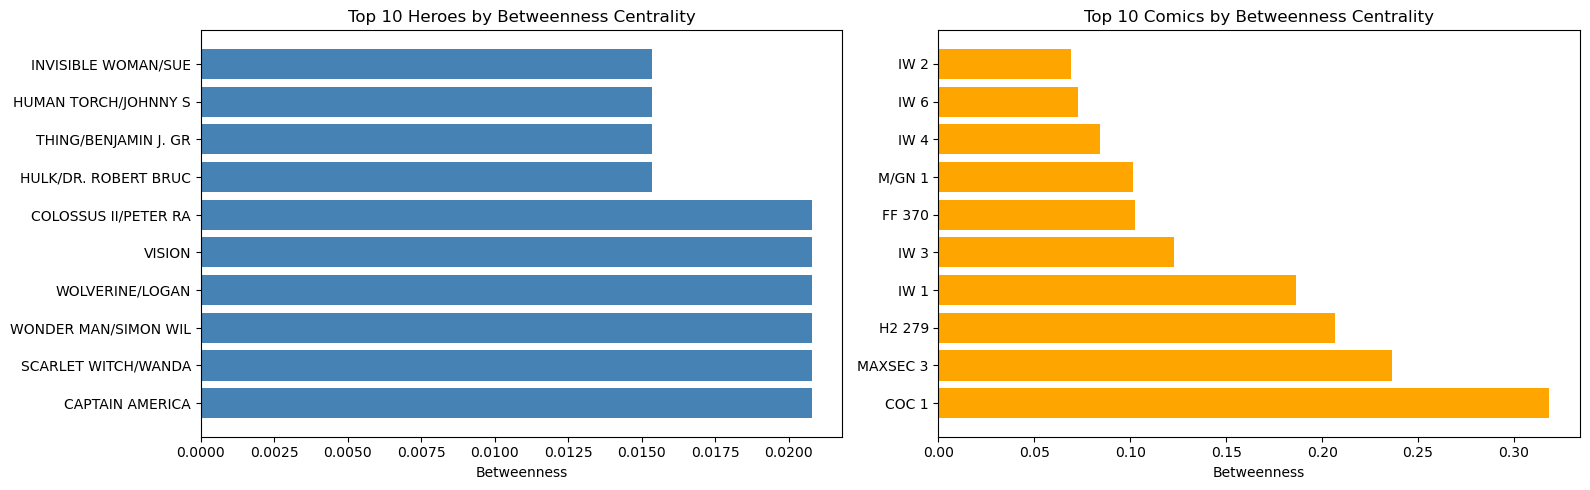

In [19]:
#Visualisation of Betweenness Centrality
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Heroes
axes[0].barh(
    [n for n, _ in reversed(top_heroes)],
    [c for _, c in reversed(top_heroes)],
    color='steelblue'
)
axes[0].set_title('Top 10 Heroes by Betweenness Centrality')
axes[0].set_xlabel('Betweenness')
axes[0].invert_yaxis()

# Comics
axes[1].barh(
    [n for n, _ in reversed(top_comics)],
    [c for _, c in reversed(top_comics)],
    color='orange'
)
axes[1].set_title('Top 10 Comics by Betweenness Centrality')
axes[1].set_xlabel('Betweenness')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## 4.2 Hero-Hero Projection

In [21]:
# Identify bipartite sets from the original graph
heroes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# Create projections where the edges are weighted by the number of common comics
hero_hero_proj = bipartite.weighted_projected_graph(B, heroes)

# Quick stats
print(f"Hero–Hero projection: {hero_hero_proj.number_of_nodes()} nodes, {hero_hero_proj.number_of_edges()} edges")


Hero–Hero projection: 6439 nodes, 171644 edges


### 4.2.1 Graph Exploration

In [36]:
projection = hero_hero_proj

# 1. Compute basic metrics
degree_dict = dict(projection.degree())
strength_dict = dict(projection.degree(weight='weight'))
betweenness_dict = nx.betweenness_centrality(projection, weight='weight')
closeness_dict = nx.closeness_centrality(projection)
eigenvector_dict = nx.eigenvector_centrality(projection, weight='weight')
clustering_dict = nx.clustering(projection, weight='weight')

# 2. Community detection (assign each node a community label)
communities = greedy_modularity_communities(projection)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 3. Create the DataFrame
hero_stats_df = pd.DataFrame({
    'Degree': pd.Series(degree_dict),
    'Strength': pd.Series(strength_dict),
    'Betweenness': pd.Series(betweenness_dict),
    'Closeness': pd.Series(closeness_dict),
    'Eigenvector': pd.Series(eigenvector_dict),
    'Clustering Coef': pd.Series(clustering_dict),
    'Community': pd.Series(community_dict)
})

# Display top 10 by eigenvector centrality, for example
hero_stats_df.sort_values('Eigenvector', ascending=False).head(10)


,Degree,Strength,Betweenness,Closeness,Eigenvector,Clustering Coef,Community
CAPTAIN AMERICA,1919,16057,0.029593,0.582825,0.273361,0.000627,1
THING/BENJAMIN J. GR,1448,10772,0.017966,0.558194,0.231308,0.000760,1
HUMAN TORCH/JOHNNY S,1412,10377,0.018101,0.555952,0.227829,0.000767,1
IRON MAN/TONY STARK,1566,11997,0.025439,0.562087,0.225258,0.000686,1
MR. FANTASTIC/REED R,1416,9886,0.018363,0.556389,0.222814,0.000733,1
SCARLET WITCH/WANDA,1362,10168,0.011130,0.553054,0.215719,0.000855,1
INVISIBLE WOMAN/SUE,1273,9415,0.012538,0.548905,0.214454,0.000862,1
VISION,1243,9786,0.008445,0.546549,0.210616,0.000991,1
THOR/DR. DONALD BLAK,1315,11558,0.015394,0.550614,0.199530,0.000910,1
WASP/JANET VAN DYNE,1108,8528,0.008540,0.538368,0.196830,0.001084,1


### 4.2.2 Isolated nodes

In [22]:
# Get all isolated nodes (nodes with degree 0)
isolated_nodes = list(nx.isolates(hero_hero_proj))

# Show counts and optionally the actual names
print(f"Number of isolated heroes: {len(isolated_nodes)}")

# See their names
print("Isolated heroes:", isolated_nodes)

Number of isolated heroes: 18
Isolated heroes: ['LUNATIK II', 'GERVASE, LADY ALYSSA', 'CLUMSY FOULUP', 'RUNE', 'ZANTOR', 'BLARE/', 'GIURESCU, RADU', 'RANDAK', 'SEA LEOPARD', 'JOHNSON, LYNDON BAIN', 'CALLAHAN, DANNY', 'KULL', 'DEATHCHARGE', 'FENRIS', 'MARVEL BOY II/MARTIN', 'RED WOLF II', 'BERSERKER II', 'SHARKSKIN']


### 4.2.3 Visualisations
We will now visualise a sub-graph of the hero-hero projection. The subgraph is composed of the top 10 nodes with the highest degree value.

In [39]:
# Top 20 heroes by degree
top_heroes = sorted(hero_hero_proj.degree, key=lambda x: x[1], reverse=True)[:10]
top_hero_nodes = [node for node, _ in top_heroes]
H_subgraph = hero_hero_proj.subgraph(top_hero_nodes)


**Heatmap of adjacency matrix**  
Since we have a weighted graph, we can visualise the edges weights between the top 10 heroes as a matrix.

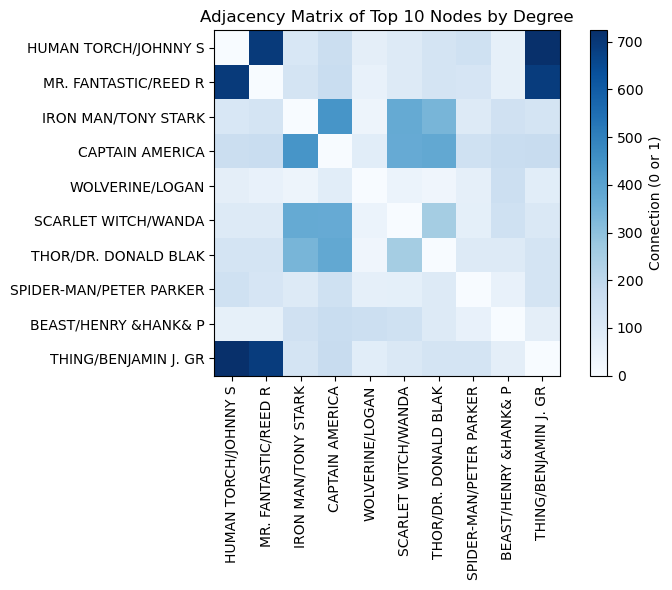

In [ ]:
# Compute degrees and sort them (highest to lowest)
degrees = dict(H_subgraph.degree())
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 nodes based on degree
top_10_nodes = [node for node, _ in sorted_nodes[:10]]

# Create subgraph of just those top 10 nodes
top10_subgraph = H_subgraph.subgraph(top_10_nodes)

# Create the adjacency matrix as a DataFrame (for better labeling)
adj_matrix = nx.to_pandas_adjacency(top10_subgraph, nodelist=top_10_nodes)

# Plot the adjacency matrix
plt.figure(figsize=(8, 6))
plt.imshow(adj_matrix, cmap='Blues', interpolation='none')

# Set axis ticks and labels
plt.xticks(ticks=range(len(top_10_nodes)), labels=top_10_nodes, rotation=90)
plt.yticks(ticks=range(len(top_10_nodes)), labels=top_10_nodes)

# Add grid and title
plt.grid(False)
plt.title("Adjacency Matrix of Top 10 Nodes by Degree")

# Show color bar
plt.colorbar(label='Connection (0 or 1)')

plt.tight_layout()
plt.show()


- HUMAN TORCH/JOHNNY S has a very dark cell with THING/BENJAMIN J. GR:→ This means they collaborated or co-appeared very frequently (strong connection).
- IRON MAN/TONY STARK and CAPTAIN AMERICA also have a darker cell between them: → They’re often linked (e.g., both Avengers).
- If a row/column is mostly light (e.g., WOLVERINE/LOGAN), it means that node has fewer or weaker connections with others in the top 10.

### 4.2.4 Community Detection  
Using Greedy Modularity

In [58]:
# Using the Greedy Modularity (fast and good for large graphs)
communities = list(greedy_modularity_communities(hero_hero_proj))
print(f"Detected {len(communities)} communities")

# Build a summary graph of communities:
summary_graph = nx.Graph()
for i, com in enumerate(communities):
    summary_graph.add_node(i, size=len(com))



Detected 117 communities


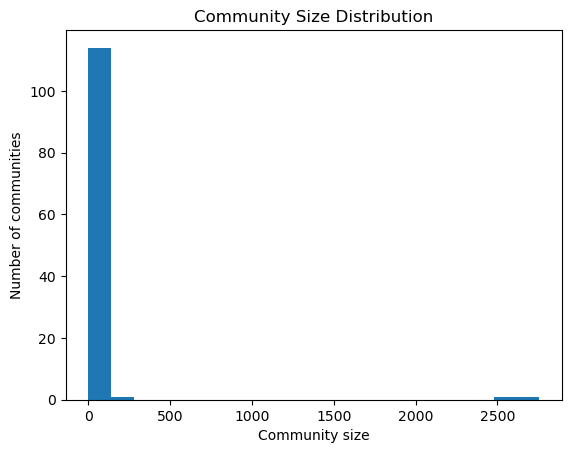

In [43]:
# Community size distribution
community_sizes = [len(c) for c in communities]
plt.hist(community_sizes, bins=20)
plt.title("Community Size Distribution")
plt.xlabel("Community size")
plt.ylabel("Number of communities")
plt.show()


In [44]:
# Top heroes in each community
for i, community in enumerate(communities[:5]):
    print(f"\nCommunity {i + 1} — {len(community)} heroes")
    degrees = hero_hero_proj.subgraph(community).degree()
    top_heroes = sorted(degrees, key=lambda x: x[1], reverse=True)[:5]
    for hero, deg in top_heroes:
        print(f"  {hero} (degree: {deg})")



Community 1 — 2756 heroes
  SPIDER-MAN/PETER PARKER (degree: 1005)
  WOLVERINE/LOGAN (degree: 799)
  BEAST/HENRY &HANK& P (degree: 679)
  MARVEL GIRL/JEAN GRE (degree: 676)
  STORM/ORORO MUNROE S (degree: 675)

Community 2 — 2511 heroes
  CAPTAIN AMERICA (degree: 1344)
  IRON MAN/TONY STARK (degree: 1135)
  SCARLET WITCH/WANDA (degree: 1009)
  VISION (degree: 987)
  THOR/DR. DONALD BLAK (degree: 970)

Community 3 — 171 heroes
  MERRYWEATHER, IRENE (degree: 65)
  BLACK FOX/ROBERT W. (degree: 52)
  PIXIE/ [ETERNAL] (degree: 51)
  EFFIGY/LT. VELMAX/JA (degree: 50)
  MR. JUSTICE/TIMOTHY (degree: 47)

Community 4 — 117 heroes
  BRUTE | MUTANT X-VER (degree: 115)
  BLOODSTORM | MUTANT (degree: 115)
  ICE-MAN | MUTANT X-V (degree: 114)
  SUMMERS, SCOTT III | (degree: 93)
  MAGNETO | MUTANT X-V (degree: 85)

Community 5 — 69 heroes
  RADIUS/JARED CORBO (degree: 47)
  MURMUR II/ARLETTE TR (degree: 47)
  FLEX/ADRIAN CORBO (degree: 44)
  GUARDIAN V/JAMES MAC (degree: 44)
  MANBOT/BERNIE LACHEN (

## 4.3 Comic-Comic Projection

In [59]:
# Identify bipartite sets from the original graph
comics = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

# Create projection where the edges are weighted by the number of common heroes
comic_comic_proj = bipartite.weighted_projected_graph(B, comics)

# Quick stats
print(f"Comic–Comic projection: {comic_comic_proj.number_of_nodes()} nodes, {comic_comic_proj.number_of_edges()} edges")

Comic–Comic projection: 12651 nodes, 7022085 edges


In [60]:
projection = comic_comic_proj

# 1. Compute basic metrics
degree_dict = dict(projection.degree())
strength_dict = dict(projection.degree(weight='weight'))
betweenness_dict = nx.betweenness_centrality(projection, weight='weight')
closeness_dict = nx.closeness_centrality(projection)
eigenvector_dict = nx.eigenvector_centrality(projection, weight='weight')
clustering_dict = nx.clustering(projection, weight='weight')

# 2. Community detection (assign each node a community label)
communities = greedy_modularity_communities(projection)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 3. Create the DataFrame
comic_stats_df = pd.DataFrame({
    'Degree': pd.Series(degree_dict),
    'Strength': pd.Series(strength_dict),
    'Betweenness': pd.Series(betweenness_dict),
    'Closeness': pd.Series(closeness_dict),
    'Eigenvector': pd.Series(eigenvector_dict),
    'Clustering Coef': pd.Series(clustering_dict),
    'Community': pd.Series(community_dict)
})

# Display top 10 by eigenvector centrality, for example
comic_stats_df.sort_values('Eigenvector', ascending=False).head(10)

KeyboardInterrupt: 

# 5. Network Analysis

## 5.1 Recommender System

In [ ]:
'''
Initialize the matrix with heros as
'''

hero_appear_in_comic_matrix = edges_df.pivot_table(
    index='hero',
    columns='comic', # comics as colums ...
    aggfunc=lambda x: 1, # If hero appears fill in 1
    fill_value=0 # In case the hero does not appear fill the NaN with a 0.
)
hero_appear_in_comic_matrix.columns.name = None
print(hero_appear_in_comic_matrix)

In [ ]:
def predict_unseen_comics(hero_name, hero_comic_matrix, k=5):
    from sklearn.metrics.pairwise import cosine_similarity

    '''
    Fetch all the appeard-in vectors from the heros ..
    '''
    value_matrix  = hero_comic_matrix.values
    heroes = hero_comic_matrix.index.tolist()
    comics = hero_comic_matrix.columns.tolist()

    # Fetch the index of the active/target hero
    id = heroes.index('ANGEL/WARREN KENNETH')
    active_vector = value_matrix[id:id+1]

    '''
    Calculate the cosine similarity between the "active" hero and all other heros
    '''
    similarities = cosine_similarity(active_vector, value_matrix).flatten()

    '''
    Extract the top K neighbours ...
    '''
    neighbor_indices = similarities.argsort()[::-1][1:k+1]
    neighbor_weights = similarities[neighbor_indices]
    neighbor_vectors = value_matrix[neighbor_indices]

    # Calculate the weighted sum of the vectors from the neighbors ..
    weighted_sum = np.dot(neighbor_weights, neighbor_vectors)

    # Only keep the comics the active hero has not appeared in to make the prediction ..
    # Build a boolean list with it where true equals hero has not appeared in.
    comics_mask = active_vector.flatten() == 0
    predicted_scores = weighted_sum * comics_mask

    # Result datarame ..
    score_df = pd.DataFrame({
        'comic': comics,
        'score': predicted_scores
    }).sort_values(by='score', ascending=False)

    # Remove all scores that are <= 0 (effectively just 0 as cosine similarity is never below 0.
    score_df = score_df[score_df['score'] > 0]

    return score_df

'''
A small example on how to use the prediction function with active Hero ZOTA and k = 5 to be selected neighbours
'''

top_predictions = predict_unseen_comics("ANGEL/WARREN KENNETH", hero_appear_in_comic_matrix, k=5)
print(top_predictions.head(10))

## 5.1 LPFormer